In [1]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
def locate_index(value,bin_min,step_size,num_bins):
  loc0 = (value-bin_min)/step_size
  if loc0 < 0:
    loc = 0
  elif loc0 >= num_bins:
    loc = num_bins-1
  else:
    loc = int(loc0)
  return loc

def shift_hist(old_hist,shift):
  if shift<0:
    left_end = sum(old_hist[:(abs(shift)+1)])
    rest = old_hist[(abs(shift)+1):]
    fill = np.zeros(len(old_hist)-1-len(rest))
    new_hist = np.concatenate(([left_end],rest,fill))
  elif shift>0:
    right_end = sum(old_hist[-(abs(shift)+1):])
    rest = old_hist[:-(abs(shift)+1)]
    fill = np.zeros(len(old_hist)-1-len(rest))
    new_hist = np.concatenate((fill,rest,[right_end]))
  else:
    new_hist = old_hist
  return new_hist

def ind_hist2tilde(hist_j,loc):
  cumsum = np.cumsum(np.sum(hist_j,axis=0))
  n = cumsum[-1]
  percentile = (cumsum[loc]+1)/(n+2)
  eps_tilde_j = ss.norm.ppf(percentile)
  return eps_tilde_j

def pop_hist2tilde(hist_j,loc):
  cumsum = np.cumsum(hist_j)
  n = cumsum[-1]
  percentile = (cumsum[loc]+1)/(n+2)
  eps_tilde_j = ss.norm.ppf(percentile)
  return eps_tilde_j

def eps2tilde(eps):
  temp = eps.argsort()
  ranks = np.empty_like(temp)
  ranks[temp] = np.arange(len(eps))
  eps_tilde = ss.norm.ppf((ranks+1)/(len(eps)+1))
  return eps_tilde

def compute_mu(memory_vec,period):
  num = (len(memory_vec)//period)*period
  mu = np.mean(memory_vec[np.arange(-num,0)])
  return mu

In [3]:
def pop_initialize(initial_data_dict,r,num_bins):
  memory_dict = initial_data_dict
  pop_hist = {}
  pop_params = {}
  betw_dict = {}
  with_dict = {}
  person_day = 0
  shape = initial_data_dict[list(initial_data_dict.keys())[0]].shape
  if len(shape)==1:
    d = shape[0]
  else:
    d = shape[1]
  pop_params["D"] = d
  ## count how many person_day each user contributed in the initialization
  for ID in initial_data_dict.keys():
    if len(initial_data_dict[ID].shape)==1:
      pop_params[ID]=1
      person_day = person_day + 1
    else:
      pop_params[ID]=initial_data_dict[ID].shape[0]
      person_day = person_day + initial_data_dict[ID].shape[0]
  pop_params["N"] = person_day
  
  ## make histogram for each feature
  for j in range(d):
    temp = []
    for ID in initial_data_dict.keys():
      if len(initial_data_dict[ID].shape)==1:
        temp.append(initial_data_dict[ID][j])
      else:
        temp = temp + initial_data_dict[ID][:,j].tolist()
    temp = np.array(temp)  
    bin_max = max(temp) + r*(max(temp)-min(temp))  ## padding width 0.4*(max-min)
    bin_min = min(temp) - r*(max(temp)-min(temp)) 
    step_size = (bin_max-bin_min)/num_bins
    pop_params[j] = [bin_min,step_size]
    freq = np.zeros(num_bins)
    for i in range(len(temp)):
      loc = locate_index(temp[i],bin_min,step_size,num_bins)
      freq[loc] = freq[loc]+1
    pop_hist[j] = freq
    
  ## use the histogram to compute tilde, and covariance matrix
  all_tilde_dict = {}
  aggregate_tilde = []
  for ID in initial_data_dict.keys():
    all_tilde_list = []
    dat = initial_data_dict[ID]
    if len(dat.shape)==1:
      tilde = np.zeros(len(dat))
      for j in range(len(dat)):
        loc = locate_index(dat[j],pop_params[j][0],pop_params[j][1],num_bins)
        tilde[j] = pop_hist2tilde(pop_hist[j],loc)
      all_tilde_list.append(tilde)
      aggregate_tilde.append(tilde)
    else:
      for i in range(dat.shape[0]):
        tilde = np.zeros(dat.shape[1])
        for j in range(dat.shape[1]):
          loc = locate_index(dat[i,j],pop_params[j][0],pop_params[j][1],num_bins)
          tilde[j] = pop_hist2tilde(pop_hist[j],loc)
        all_tilde_list.append(tilde)
        aggregate_tilde.append(tilde)
    all_tilde_dict[ID] = all_tilde_list
  
  cov = np.cov(np.array(aggregate_tilde),rowvar=False)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  pop_params["var"] = var
  
  ## use the covariance matrix and tilde to get final test stats
  for ID in all_tilde_dict.keys():
    dat = all_tilde_dict[ID]
    betw_dict[ID] = []
    for i in range(len(dat)):
      stat_betw = np.array(dat[i]).dot(np.linalg.pinv(var)).dot(np.array(dat[i]))
      betw_dict[ID].append(stat_betw)
  return pop_params, pop_hist, memory_dict, betw_dict, with_dict

In [4]:
def pop_update(ID, dayk_data_dict, pop_params,pop_hist):
  pop_params[ID] = pop_params[ID]+1
  pop_params["N"] = pop_params["N"]+1
  num_bins = len(pop_hist[0])
  tilde = np.zeros(pop_params["D"])
  for j in range(pop_params["D"]):
    loc = locate_index(dayk_data_dict[ID][j],pop_params[j][0],pop_params[j][1],num_bins)
    pop_hist[j][loc] = pop_hist[j][loc] + 1
    tilde[j] = pop_hist2tilde(pop_hist[j],loc)
  cov = (pop_params["N"]-1)/pop_params["N"]*pop_params["var"]+ \
         1/pop_params["N"]*np.outer(tilde,tilde)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  pop_params["var"] = var
  stat_betw = tilde.dot(np.linalg.pinv(pop_params["var"])).dot(tilde)
  return stat_betw,pop_params,pop_hist

In [5]:
def ind_initialize(day1tok_data,period,r,num_bins):
  stat_list = []
  ind_hist = {}
  (nrow,ncol) = day1tok_data.shape
  stats_within = np.zeros(nrow)
  eps_tilde_mat = np.zeros((nrow,ncol))
  bin_min_vec = np.zeros(ncol)
  step_size_vec = np.zeros(ncol)
  day_sum_mat = np.zeros((period,ncol))
  temporal_index = np.arange(nrow)
  periodic_index = temporal_index%period
  count = np.array([sum(periodic_index==k) for k in range(period)])
  for j in range(ncol):
    feature = day1tok_data[:,j]
    y_minus_mu = np.zeros(nrow) 
    eps_hist = np.zeros((period,num_bins))
    for i in range(nrow):
      mu = np.mean(feature)
      y_minus_mu[i] = feature[i]-mu
    day_sum = np.array([sum(y_minus_mu[periodic_index==k]) for k in range(period)])
    s = day_sum/count  ## day of the week
    eps = np.array([y_minus_mu[k]-s[k%period] for k in range(nrow)])
    eps_tilde_mat[:,j] = eps2tilde(eps)
    diff = max(eps)-min(eps)
    bin_min = min(eps)-r*diff
    bin_min_vec[j] = bin_min
    bin_max = max(eps)+r*diff
    step_size = (bin_max-bin_min)/num_bins
    step_size_vec[j] = step_size
    for i in range(nrow):
      row_loc = i%period
      col_loc = locate_index(eps[i],bin_min,step_size,num_bins)
      eps_hist[row_loc, col_loc]=eps_hist[row_loc, col_loc]+1
    ind_hist[j] = eps_hist
    day_sum_mat[:,j] = day_sum
  cov = np.cov(eps_tilde_mat,rowvar=False)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  for k in range(eps_tilde_mat.shape[0]):
    stat_list.append((eps_tilde_mat[k,:]).dot(np.linalg.pinv(var)).dot(eps_tilde_mat[k,:]))
  ind_params = {"day_sum_mat":day_sum_mat,"count":count,"bin_min_vec":bin_min_vec,
                "step_size_vec":step_size_vec,"var":var}
  return ind_params, ind_hist, stat_list

In [6]:
def ind_update(ID, dayk_data_dict, pop_params, ind_params_dict, ind_hist_dict, memory_dict):
  ind_hist = ind_hist_dict[ID]
  num_bins = ind_hist[0].shape[1]
  ind_params = ind_params_dict[ID]
  day_sum_mat = ind_params["day_sum_mat"]
  (period, ncol) = day_sum_mat.shape
  n = pop_params[ID]
  count = ind_params["count"]
  count[(n-1)%period] = count[(n-1)%period] + 1
  var = ind_params["var"]
  bin_min_vec = ind_params["bin_min_vec"]
  step_size_vec = ind_params["step_size_vec"]
  memory = memory_dict[ID]
  d = pop_params["D"]
  eps_vec = np.zeros(d)
  for j in range(d):
    mu = compute_mu(memory[:,j],period)
    y_minus_mu = dayk_data_dict[ID][j]-mu
    old_avg = day_sum_mat[(n-1)%period,j]/(count[(n-1)%period]-1)
    day_sum_mat[(n-1)%period,j] = day_sum_mat[(n-1)%period,j] +  y_minus_mu
    new_avg = day_sum_mat[(n-1)%period,j]/count[(n-1)%period] 
    shift = int(np.round((old_avg-new_avg)/step_size_vec[j],0))
    old_hist = ind_hist[j][(n-1)%period,:]
    new_hist = shift_hist(old_hist,shift)
    new_eps = y_minus_mu-new_avg
    loc = locate_index(new_eps,bin_min_vec[j],step_size_vec[j],num_bins)
    new_hist[loc] = new_hist[loc] + 1
    ind_hist[j][(n-1)%period,:] = new_hist
    eps_vec[j] = ind_hist2tilde(ind_hist[j],loc)
  cov = (n-1)/n*var+1/n*np.outer(eps_vec,eps_vec)
  std = np.sqrt(np.diag(cov))
  var = cov/np.outer(std,std)
  stat_within = eps_vec.dot(np.linalg.pinv(var)).dot(eps_vec)
  ind_params = {"day_sum_mat":day_sum_mat,"count":count,"bin_min_vec":bin_min_vec,
                "step_size_vec":step_size_vec,"var":var}
  ind_params_dict[ID] = ind_params
  ind_hist_dict[ID] = ind_hist
  return stat_within, ind_params_dict, ind_hist_dict

In [7]:
def memory_update(ID, dayk_data_dict, memory_dict, pop_params, max_m):
  if ID not in memory_dict.keys():
     memory_dict[ID] = dayk_data_dict[ID].reshape(1,-1)
  else:
    if pop_params[ID] < max_m:
      memory_dict[ID] = np.vstack((memory_dict[ID],dayk_data_dict[ID].reshape(1,-1)))
    else:
      memory_dict[ID] = memory_dict[ID][1:,:]
      memory_dict[ID] = np.vstack((memory_dict[ID],dayk_data_dict[ID].reshape(1,-1)))
  return memory_dict

def stat_update(ID,stat,stat_dict):
  if ID not in stat_dict.keys():
    stat_dict[ID] = stat
  else:
    stat_dict[ID].append(stat)
  return stat_dict

In [8]:
def online_update(dayk_data_dict,pop_params,pop_hist,ind_params_dict,ind_hist_dict,
                  memory_dict,with_dict,betw_dict,period,r,num_bins,max_m):
  for ID in dayk_data_dict.keys():
    ## if this ID already exists in the dictionary, update
    if ID in pop_params.keys():
      ## different actions based on sample size: scenario 1
      if pop_params[ID]<=27:
        memory_dict = memory_update(ID,dayk_data_dict,memory_dict,pop_params,max_m)
        stat_betw, pop_params, pop_hist = pop_update(ID,dayk_data_dict,pop_params,pop_hist)
        betw_dict = stat_update(ID,stat_betw,betw_dict)
        if pop_params[ID]==28:
            ind_params,ind_hist,stat_list = ind_initialize(memory_dict[ID],period,r,num_bins)
            ind_hist_dict[ID] = ind_hist
            ind_params_dict[ID] = ind_params
            with_dict[ID] = stat_list
      ## different actions based on sample size: scenario 2
      elif pop_params[ID]>27:
        memory_dict = memory_update(ID,dayk_data_dict,memory_dict,pop_params,max_m)
        stat_betw, pop_params, pop_hist = pop_update(ID, dayk_data_dict, pop_params, pop_hist)
        stat_with, ind_params_dict, ind_hist_dict = \
        ind_update(ID,dayk_data_dict,pop_params,ind_params_dict,ind_hist_dict,memory_dict)
        with_dict = stat_update(ID, stat_with, with_dict)
        betw_dict = stat_update(ID, stat_betw, betw_dict)
    ## if this ID doesn't exist in the dictionary, create a new key-value pair
    else:
      pop_params[ID] = 1
      pop_params["N"] = pop_params["N"]+1
      stat_betw, pop_params, pop_hist = \
      pop_update(ID, dayk_data_dict, pop_params, pop_hist)
      memory_dict = memory_update(ID, dayk_data_dict,memory_dict,pop_params,global_params)
      betw_dict = stat_update(ID, stat_betw, betw_dict)
  return pop_params,pop_hist,ind_params_dict,ind_hist_dict,\
         memory_dict,betw_dict,with_dict

In [9]:
## dynamic threshold -- empirical threshold
def find_weight(i):
  i = i + 1
  if i<28:
    return 0
  ## target: after 112 days (16 weeks), the weight increases to 1
  else:
    coef = 1/(112-28)**2
    return min(coef*(i-28)**2,1)

def find_sig_lvl(i,knot,start_lvl,end_lvl):
  i = i + 1
  if i<28:
    return start_lvl
  elif i<knot:
    return start_lvl + (end_lvl-start_lvl)/(knot-28)*(i-28)
  else:
    return end_lvl

def find_test_stat(betw_dict,with_dict,weight):
  final_stat = {}
  for ID in betw_dict.keys():
    if ID in with_dict:
      final_stat[ID] = betw_dict[ID][-1]*(1-weight)+with_dict[ID][-1]*weight
    else:
      final_stat[ID] = betw_dict[ID][-1]
  return final_stat
  
def find_threshold(betw_dict,with_dict,i,window,weight,sig_lvl):
  pool = []
  for ID in betw_dict.keys():
    index = np.arange(max(i-window,0),i+1)
    if index[0]> len(betw_dict[ID]):
      index = np.array([])
    else:
      index = index[index<len(betw_dict[ID])]
    if ID in with_dict:
      pool.extend([betw_dict[ID][j]*(1-weight)+with_dict[ID][j]*weight for j in index])
    else:
      pool.extend([betw_dict[ID][j] for j in index])
  threshold = np.percentile(np.array(pool),(1-sig_lvl)*100)
  return threshold

In [10]:
def online_anomaly_detect(data_dict,global_params):
  [period,r,num_bins,max_m,knot,start_lvl,end_lvl,window] = global_params
  ind_hist_dict = {}
  ind_params_dict = {}
  pred_dict = {}
  max_length = 0
  for ID in data_dict.keys():
    if data_dict[ID].shape[0]>max_length:
      max_length = data_dict[ID].shape[0]
  for i in range(max_length):
    if i == 0:
      print("Initialization.")
      initial_data_dict = {}
      for ID in data_dict.keys():
        initial_data_dict[ID] = data_dict[ID][i,:]
      pop_params, pop_hist, memory_dict, betw_dict, with_dict = \
      pop_initialize(initial_data_dict,r,num_bins)
    else:
      dayk_data_dict = {}
      for ID in data_dict.keys():
        if i < data_dict[ID].shape[0]:
          temp = data_dict[ID][i,:]
          temp[np.isnan(temp)]=0
          dayk_data_dict[ID]=temp
      print(i,len(dayk_data_dict))
      pop_params,pop_hist,ind_params_dict,ind_hist_dict, memory_dict,betw_dict,with_dict = \
      online_update(dayk_data_dict,pop_params,pop_hist,ind_params_dict,ind_hist_dict,\
                    memory_dict,with_dict,betw_dict,period,r,num_bins,max_m)
    weight = find_weight(i)
    sig_lvl = find_sig_lvl(i,knot,start_lvl,end_lvl)
    final_stat = find_test_stat(betw_dict,with_dict,weight)
    threshold = find_threshold(betw_dict,with_dict,i,window,weight,sig_lvl)
    for ID in betw_dict.keys():
      if ID not in pred_dict:
        pred_dict[ID]=[(final_stat[ID]>threshold)*1]
      else:
        pred_dict[ID].append((final_stat[ID]>threshold)*1)
  return pred_dict

In [11]:
def eval_perf(pred_dict,label_dict):
  fp = []
  fn = []
  tp = []
  tn = []
  for i in range(K):
    index = np.arange(max(0,i-5),i+1)
    temp_pred = []
    temp_label = []
    for ID in pred_dict.keys():
      temp_pred = temp_pred + [pred_dict[ID][j] for j in index]
      temp_label = temp_label + [label_dict[ID][j] for j in index]
    fp.append(sum((np.array(temp_pred)==1)*(np.array(temp_label)==0))/len(temp_pred))
    fn.append(sum((np.array(temp_pred)==0)*(np.array(temp_label)==1))/len(temp_pred))
    tp.append(sum((np.array(temp_pred)==1)*(np.array(temp_label)==1))/len(temp_pred))
    tn.append(sum((np.array(temp_pred)==0)*(np.array(temp_label)==0))/len(temp_pred))
  return np.array(fp),np.array(fn),np.array(tp),np.array(tn)

In [13]:
## repeat 10 times to get a plot for average type 1 error
reps = 5
fp_list = []
for rep in range(reps):
  ## without anomalies
  M = 10   ## num of users
  K = 540   ## days
  D = 10    ## variables 
  ids = ["ID"+str(i+1) for i in range(M)]
  data_dict = {}
  label_dict = {}
  scale_list = np.random.uniform(0.3,3,size=D)
  intercept_list = np.random.uniform(0.3,3,size=D)
  loc_list = np.random.uniform(0,7,size=D)
  m = np.zeros(D)
  cor = np.ones((D,D))*0.6
  for i in range(D):
    cor[i,i]=1
  v = np.diag(scale_list).dot(cor).dot(np.diag(scale_list))

  for ID in ids:
    data = np.zeros((K,D))
    random_error = np.random.multivariate_normal(m, v, size=K)
    for j in range(D):
      scale = scale_list[j]
      intercept = intercept_list[j]
      loc = loc_list[j]
      data[:,j] = np.array([scale*np.sin(2*math.pi/7*(x+loc)) for x in range(K)]) + \
                  random_error[:,j] + intercept
    data_dict[ID] = data
    label_dict[ID] = np.zeros(K)
  global_params = [7,0.4,100,28*6,56,0.05,0.05,50]
  pred_dict = online_anomaly_detect(data_dict,global_params)
  fp,fn,tp,tn = eval_perf(pred_dict,label_dict)
  fp_list.append(fp)

Initialization.
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
10 10
11 10
12 10
13 10
14 10
15 10
16 10
17 10
18 10
19 10
20 10
21 10
22 10
23 10
24 10
25 10
26 10
27 10
28 10
29 10
30 10
31 10
32 10
33 10
34 10
35 10
36 10
37 10
38 10
39 10
40 10
41 10
42 10
43 10
44 10
45 10
46 10
47 10
48 10
49 10
50 10
51 10
52 10
53 10
54 10
55 10
56 10
57 10
58 10
59 10
60 10
61 10
62 10
63 10
64 10
65 10
66 10
67 10
68 10
69 10
70 10
71 10
72 10
73 10
74 10
75 10
76 10
77 10
78 10
79 10
80 10
81 10
82 10
83 10
84 10
85 10
86 10
87 10
88 10
89 10
90 10
91 10
92 10
93 10
94 10
95 10
96 10
97 10
98 10
99 10
100 10
101 10
102 10
103 10
104 10
105 10
106 10
107 10
108 10
109 10
110 10
111 10
112 10
113 10
114 10
115 10
116 10
117 10
118 10
119 10
120 10
121 10
122 10
123 10
124 10
125 10
126 10
127 10
128 10
129 10
130 10
131 10
132 10
133 10
134 10
135 10
136 10
137 10
138 10
139 10
140 10
141 10
142 10
143 10
144 10
145 10
146 10
147 10
148 10
149 10
150 10
151 10
152 10
153 10
154 10
155 10
156 10


137 10
138 10
139 10
140 10
141 10
142 10
143 10
144 10
145 10
146 10
147 10
148 10
149 10
150 10
151 10
152 10
153 10
154 10
155 10
156 10
157 10
158 10
159 10
160 10
161 10
162 10
163 10
164 10
165 10
166 10
167 10
168 10
169 10
170 10
171 10
172 10
173 10
174 10
175 10
176 10
177 10
178 10
179 10
180 10
181 10
182 10
183 10
184 10
185 10
186 10
187 10
188 10
189 10
190 10
191 10
192 10
193 10
194 10
195 10
196 10
197 10
198 10
199 10
200 10
201 10
202 10
203 10
204 10
205 10
206 10
207 10
208 10
209 10
210 10
211 10
212 10
213 10
214 10
215 10
216 10
217 10
218 10
219 10
220 10
221 10
222 10
223 10
224 10
225 10
226 10
227 10
228 10
229 10
230 10
231 10
232 10
233 10
234 10
235 10
236 10
237 10
238 10
239 10
240 10
241 10
242 10
243 10
244 10
245 10
246 10
247 10
248 10
249 10
250 10
251 10
252 10
253 10
254 10
255 10
256 10
257 10
258 10
259 10
260 10
261 10
262 10
263 10
264 10
265 10
266 10
267 10
268 10
269 10
270 10
271 10
272 10
273 10
274 10
275 10
276 10
277 10
278 10
279 10

259 10
260 10
261 10
262 10
263 10
264 10
265 10
266 10
267 10
268 10
269 10
270 10
271 10
272 10
273 10
274 10
275 10
276 10
277 10
278 10
279 10
280 10
281 10
282 10
283 10
284 10
285 10
286 10
287 10
288 10
289 10
290 10
291 10
292 10
293 10
294 10
295 10
296 10
297 10
298 10
299 10
300 10
301 10
302 10
303 10
304 10
305 10
306 10
307 10
308 10
309 10
310 10
311 10
312 10
313 10
314 10
315 10
316 10
317 10
318 10
319 10
320 10
321 10
322 10
323 10
324 10
325 10
326 10
327 10
328 10
329 10
330 10
331 10
332 10
333 10
334 10
335 10
336 10
337 10
338 10
339 10
340 10
341 10
342 10
343 10
344 10
345 10
346 10
347 10
348 10
349 10
350 10
351 10
352 10
353 10
354 10
355 10
356 10
357 10
358 10
359 10
360 10
361 10
362 10
363 10
364 10
365 10
366 10
367 10
368 10
369 10
370 10
371 10
372 10
373 10
374 10
375 10
376 10
377 10
378 10
379 10
380 10
381 10
382 10
383 10
384 10
385 10
386 10
387 10
388 10
389 10
390 10
391 10
392 10
393 10
394 10
395 10
396 10
397 10
398 10
399 10
400 10
401 10

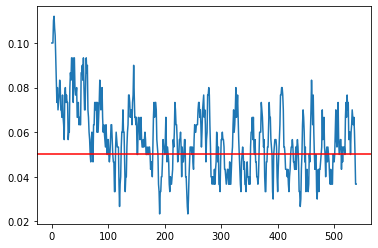

In [14]:
e_fp = []
for i in range(len(fp)):
  e_fp.append(np.mean(np.array([fp_list[j][i] for j in range(reps)])))
plt.plot(range(len(e_fp)),e_fp)
plt.axhline(y=0.05, color='r', linestyle='-')